In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 
import json

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl
import cbmos.utils as ut
import cbmos.events as ev

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
import scipy
scipy.__version__

'1.5.4'

In [3]:
s = 1.0
rA = 1.5
params_cubic = {'mu': 5.7, 's': s, 'rA': rA}
dim = 3
seed = 67
tf = 1500.0 # in order to reach 1000 cells (starting at 512)
frequency = 1.0

In [4]:
#algorithms
#algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap', 'fixed_dt']


models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 1e-4
eps = 0.005

params = {'EF_glob_adap_acc': {'eps': eps, 'eta': eta},
          'EF_glob_adap_stab': {'eps': eps, 'eta': eta, 
                                'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 
                                'always_calculate_Jacobian': True, 
                                #'calculate_eigenvalues': True
                               }, 
          'EF_local_adap': {'eps': eps, 'eta': eta, 
                            'jacobian': models['EF_local_adap'].jacobian, 'force_args': params_cubic, 
                            'always_calculate_Jacobian': True, 
                            'local_adaptivity': True, 'm0': 14, 
                            #'calculate_eigenvalues': True
                            #'dim': dim, 
                            'rA': rA 
                           }, 
          'EB_global_adap': {'eps': eps, 'eta': eta, 'jacobian': models['EB_global_adap'].jacobian, 'force_args': params_cubic}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (SRFE)', 
          'EF_glob_adap_stab': 'Alg. II (SRFES)' ,  
          'EF_local_adap': 'Alg. III (MRFE)', 
          'EB_global_adap': 'Alg. IV (GABE)',
          'fixed_dt': 'dt fixed'
         }
defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'EF_glob_adap_acc': defcolors[0], 
          'EF_glob_adap_stab': defcolors[1] ,  
          'EF_local_adap': defcolors[2], 
          'EB_global_adap': defcolors[3], 
          'fixed_dt' : defcolors[5]}

Data:

Version 1: 
- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 10 0.05
- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 10 0.5
- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 10 5

- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 11 0.05
- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 11 0.5

- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 12 0.05
- python3 exp-linear_tissue_growth_script.py ../data/20220506_lin_growth 12 0.5

Version 2: (only add 10 cells, but do 4 repetions):


In [5]:
dates = {0.1: '20220506', 0.5: '20220507', 1.0: '20220507'}
times_between_divisions = [0.1, 0.5, 1.0]
base_sizes = [13, 14, 15]

In [6]:
alg = 'fixed_dt'
data_fixed_dt = {}
for size in base_sizes:
    times = []
    for tbe in times_between_divisions:
        with open('data/'+dates[tbe]+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
            wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        times.append(wall_time) 
    data_fixed_dt[size] = times


In [7]:
data_fixed_dt

{13: [86.68667089939117, 422.953333735466, 892.1566143631935],
 14: [124.47029334306717, 613.3651329278946, 1249.2150719165802],
 15: [187.736481487751, 909.0834839940071, 1866.6468936800957]}

In [9]:
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap' ]
data = {}
for alg in algorithms:
    data[alg] = {}
    for size in base_sizes:
        times = []
        for tbe in times_between_divisions:
            with open('data/'+dates[tbe]+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
                wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
            times.append(wall_time) 
        data[alg][size] = np.array(times)/np.array(data_fixed_dt[size])

In [15]:
alg = 'EB_global_adap'
data[alg] = {}
for size in [13, 14]:
    times = []
    for tbe in times_between_divisions:
        with open('data/'+dates[tbe]+'_rackham_'+str(size)+'_'+str(tbe)+'_'+alg+'.json', 'r') as f:
            wall_time = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        times.append(wall_time) 
    data[alg][size] = np.array(times)/np.array(data_fixed_dt[size])

In [16]:
data

{'EF_glob_adap_acc': {13: array([0.96418467, 0.32880137, 0.18731535]),
  14: array([1.04505745, 0.33897468, 0.20213707]),
  15: array([1.06153564, 0.33987165, 0.215483  ])},
 'EF_glob_adap_stab': {13: array([2.49560945, 1.04722348, 0.78953804]),
  14: array([2.70419763, 1.09616626, 0.83183889]),
  15: array([2.74320386, 1.08668794, 0.89903277])},
 'EF_local_adap': {13: array([1.23166386, 0.78596752, 0.67373701]),
  14: array([1.3344842 , 0.82944911, 0.74289752]),
  15: array([1.32646226, 0.79038353, 0.7556506 ])},
 'EB_global_adap': {13: array([6.36349316, 2.28525191, 1.427583  ]),
  14: array([6.83585185, 2.36371669, 1.48230909])}}

In [18]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=defcolors[0], lw=3),
                Line2D([0], [0], color=defcolors[1], lw=3),
                Line2D([0], [0], color=defcolors[2], lw=3),
                Line2D([0], [0], color=defcolors[3], lw=3)]

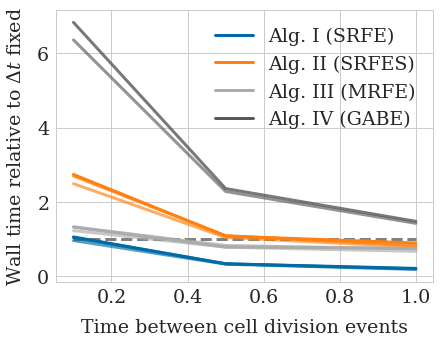

In [26]:
plt.plot(times_between_divisions, np.ones(len(times_between_divisions)), '--', color='grey')
for alg in algorithms:
    for size in base_sizes:
        plt.plot(times_between_divisions, data[alg][size], color=colors[alg], alpha=(size**3)/np.max(base_sizes)**3)
alg = 'EB_global_adap'
for size in [13, 14]:
    plt.plot(times_between_divisions, data[alg][size], color=colors[alg], alpha=(size**3)/np.max(base_sizes)**3)
plt.xlabel('Time between cell division events')
plt.ylabel('Wall time relative to $\Delta t$ fixed')
plt.legend(custom_lines, [labels['EF_glob_adap_acc'], labels['EF_glob_adap_stab'] ,  labels['EF_local_adap'], labels['EB_global_adap'] ])

plt.savefig('linear_tissue_growth_relative_wall_time.pdf', bbox_inches='tight')

Do speed-up instead???

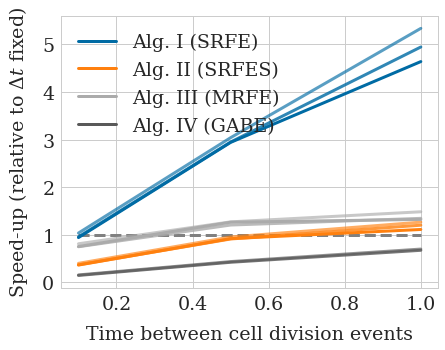

In [28]:
plt.plot(times_between_divisions, np.ones(len(times_between_divisions)), '--', color='grey')
for alg in algorithms:
    for size in base_sizes:
        plt.plot(times_between_divisions, 1.0/data[alg][size], color=colors[alg], alpha=(size**3)/np.max(base_sizes)**3)
alg = 'EB_global_adap'
for size in [13, 14]:
    plt.plot(times_between_divisions, 1.0/data[alg][size], color=colors[alg], alpha=(size**3)/np.max(base_sizes)**3)
plt.xlabel('Time between cell division events')
plt.ylabel('Speed-up (relative to $\Delta t$ fixed)')
plt.legend(custom_lines, [labels['EF_glob_adap_acc'], labels['EF_glob_adap_stab'] ,  labels['EF_local_adap'], labels['EB_global_adap'] ])

plt.savefig('linear_tissue_growth_speed_up.pdf', bbox_inches='tight')

In [16]:
with open('data/20220506_lin_growth_v2_'+str(10)+'_0.05_fixed_dt.json', 'r') as f:
    data = np.array(json.load(f)['counts'])[:, 0, 2]
    #wall_times_fixed_dt = np.mean(np.array(json.load(f)['counts'])[:,2])

In [18]:
data[:, 0, 2]

array([4.49959517, 4.45897341, 4.44479108, 4.44191217])

Text(0.5, 1.0, 'f=1/1.0')

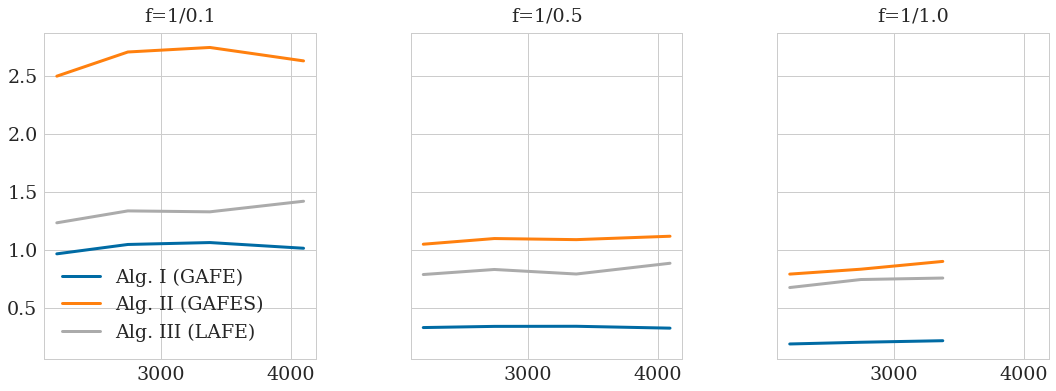

In [60]:
# Version 2 data:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'hspace':0.2, 'wspace': 0.35}, sharey=True, sharex=True)

algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap' ]


## axis 1
for alg in algorithms:
    relative_wall_times = []
#    for size in [10, 11, 12]:   
#        with open('data/20220506_lin_growth_v2_'+str(size)+'_0.05_fixed_dt.json', 'r') as f:
#            wall_times_fixed_dt = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        
#    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
#        with open('data/20220506_lin_growth_v2_'+str(size)+'_0.05_'+alg+'.json', 'r') as f:
#            wall_times = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
#            relative_wall_times.append(wall_times/wall_times_fixed_dt)  
    for size in [13, 14, 15, 16]:
        with open('data/20220506_rackham_'+str(size)+'_0.1_fixed_dt.json', 'r') as f:
            wall_times_fixed_dt = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
        with open('data/20220506_rackham_'+str(size)+'_0.1_'+alg+'.json', 'r') as f:
            wall_times = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
            relative_wall_times.append(wall_times/wall_times_fixed_dt) 
            
    ax1.plot([13**3, 14**3, 15**3, 16**3], relative_wall_times, label=labels[alg])
    
## axis 2
for alg in algorithms:
    relative_wall_times = []
#    for size in [10, 11, 12]:   
#        with open('data/20220506_lin_growth_'+str(size)+'_0.5_fixed_dt.json', 'r') as f:
#            wall_times_fixed_dt = np.array(json.load(f)['counts'])[:,2]
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
#        with open('data/20220506_lin_growth_'+str(size)+'_0.5_'+alg+'.json', 'r') as f:
#            wall_times = np.array(json.load(f)['counts'])[:,2]
#            relative_wall_times.append(np.mean(wall_times[1:]/wall_times_fixed_dt[1:])) 
            
    for size in [13, 14, 15, 16]:
        with open('data/20220507_rackham_'+str(size)+'_0.5_fixed_dt.json', 'r') as f:
            wall_times_fixed_dt = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
        with open('data/20220507_rackham_'+str(size)+'_0.5_'+alg+'.json', 'r') as f:
            wall_times = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
            relative_wall_times.append(wall_times/wall_times_fixed_dt) 
            
    #ax1.plot([13**3, 14**3, 15**3], relative_wall_times, label=labels[alg])
            
    ax2.plot([13**3, 14**3, 15**3, 16**3], relative_wall_times, label=labels[alg])
    
## axis 3
for alg in algorithms:
    relative_wall_times = []
#    for size in [10, 11, 12]:   
#        with open('data/20220506_lin_growth_'+str(size)+'_0.5_fixed_dt.json', 'r') as f:
#            wall_times_fixed_dt = np.array(json.load(f)['counts'])[:,2]
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
#        with open('data/20220506_lin_growth_'+str(size)+'_0.5_'+alg+'.json', 'r') as f:
#            wall_times = np.array(json.load(f)['counts'])[:,2]
#            relative_wall_times.append(np.mean(wall_times[1:]/wall_times_fixed_dt[1:])) 
            
    for size in [13, 14, 15]:
        with open('data/20220507_rackham_'+str(size)+'_1.0_fixed_dt.json', 'r') as f:
            wall_times_fixed_dt = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
        with open('data/20220507_rackham_'+str(size)+'_1.0_'+alg+'.json', 'r') as f:
            wall_times = np.mean(np.array(json.load(f)['counts'])[:, 0, 2])
            relative_wall_times.append(wall_times/wall_times_fixed_dt) 
                        
    ax3.plot([13**3, 14**3, 15**3], relative_wall_times, label=labels[alg])
            
ax1.legend()

ax1.set_title('f=1/0.1')
ax2.set_title('f=1/0.5')
ax3.set_title('f=1/1.0')

In [38]:
data_005 = {}
for alg in algorithms:
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
    with open('data/20220506_lin_growth_12_0.05_'+alg+'.json', 'r') as f:
        data_005[alg] = json.load(f)

In [39]:
data_05 = {}
for alg in algorithms:
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
    with open('data/20220506_lin_growth_12_0.5_'+alg+'.json', 'r') as f:
        data_05[alg] = json.load(f)

In [36]:
data_5 = {}
for alg in algorithms:
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
    with open('data/20220506_lin_growth_10_5.0_'+alg+'.json', 'r') as f:
        data_5[alg] = json.load(f)

In [28]:
data['fixed_dt']['counts']

[[0, 1000, 0.1511533260345459],
 [0.5, 1010, 4.489296913146973],
 [1.0, 1020, 8.887713432312012]]

Text(0.5, 1.0, 'f=1/5.0')

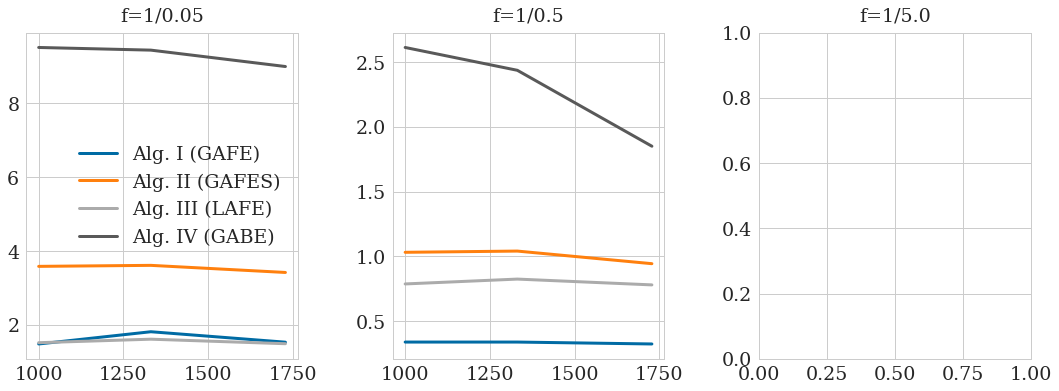

In [61]:
# Version 1 data:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'hspace':0.2, 'wspace': 0.35})

algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

## axis 1
for alg in algorithms:
    relative_wall_times = []
    for size in [10, 11, 12]:   
        with open('data/20220506_lin_growth_'+str(size)+'_0.05_fixed_dt.json', 'r') as f:
            wall_times_fixed_dt = np.array(json.load(f)['counts'])[:,2]
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
        with open('data/20220506_lin_growth_'+str(size)+'_0.05_'+alg+'.json', 'r') as f:
            wall_times = np.array(json.load(f)['counts'])[:,2]
            relative_wall_times.append(np.mean(wall_times[1:]/wall_times_fixed_dt[1:]))  
            
    ax1.plot([10**3, 11**3, 12**3], relative_wall_times, label=labels[alg])
    
## axis 2
for alg in algorithms:
    relative_wall_times = []
    for size in [10, 11, 12]:   
        with open('data/20220506_lin_growth_'+str(size)+'_0.5_fixed_dt.json', 'r') as f:
            wall_times_fixed_dt = np.array(json.load(f)['counts'])[:,2]
        
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
        with open('data/20220506_lin_growth_'+str(size)+'_0.5_'+alg+'.json', 'r') as f:
            wall_times = np.array(json.load(f)['counts'])[:,2]
            relative_wall_times.append(np.mean(wall_times[1:]/wall_times_fixed_dt[1:]))  
            
    ax2.plot([10**3, 11**3, 12**3], relative_wall_times, label=labels[alg])
            
ax1.legend()

ax1.set_title('f=1/0.05')
ax2.set_title('f=1/0.5')
ax3.set_title('f=1/5.0')

In [4]:
#ancestor = [cl.Cell(0, [0.0, 0.0, 0.0])]

#start with tissue (~500 cells?)
coords = ut.generate_hcp_coordinates(8, 8, 8)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]


In [5]:
8*8*8

512

In [6]:
target_cell_counts = [520, 530, 540, 550]
max_execution_time = 10*60 # 10 minutes in seconds

In [15]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)


EF_glob_adap_acc
EF_glob_adap_stab
EF_local_adap
EB_global_adap


In [9]:
data['EF_glob_adap_acc']

array([[264.        , 600.        , 111.44063926],
       [564.        , 700.        , 286.33167768],
       [864.        , 800.        , 521.52225947]])

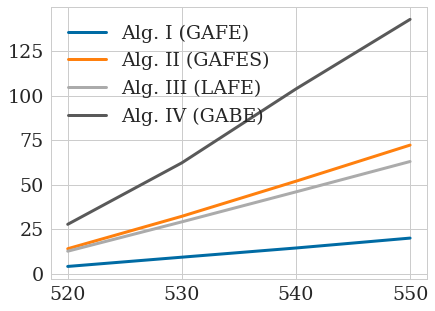

In [16]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()


In [10]:
#algorithms = ['EF_glob_adap_acc']

In [18]:
#ancestor = [cl.Cell(0, [0.0, 0.0, 0.0])]

#start with tissue (~500 cells?)
size = 9
coords = ut.generate_hcp_coordinates(size, size, size)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

frequency = 0.5
event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]

target_cell_counts = [730, 740, 750, 760]
max_execution_time = 10*60 # 10 minutes in seconds

In [19]:
9**3

729

In [22]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    plt.plot(ts[:-2], np.diff(ts[:-1]))
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)


EF_glob_adap_acc
EF_glob_adap_stab
EF_local_adap


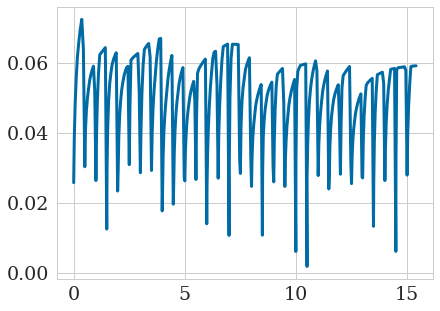

In [25]:
plt.plot(ts[:-2], np.diff(ts[:-1]))

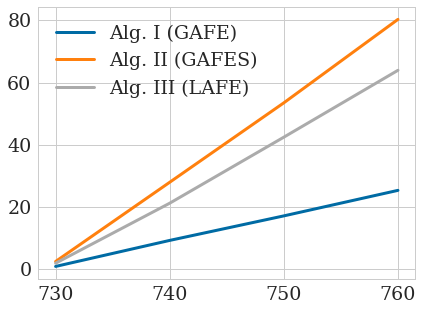

In [23]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()


In [26]:
#ancestor = [cl.Cell(0, [0.0, 0.0, 0.0])]

#start with tissue (~500 cells?)
size = 10
coords = ut.generate_hcp_coordinates(size, size, size)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

frequency = 0.5
event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]

target_cell_counts = [1010, 1020, 1030, 1040]
max_execution_time = 10*60 # 10 minutes in seconds

EF_glob_adap_acc
EF_glob_adap_stab
EF_local_adap


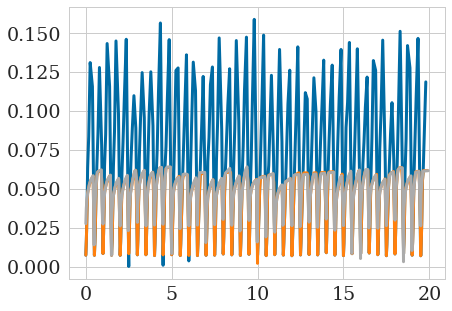

In [27]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    plt.plot(ts[:-2], np.diff(ts[:-1]))
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)

GAFE is using so much larger steps... How does this affect the accuracy?

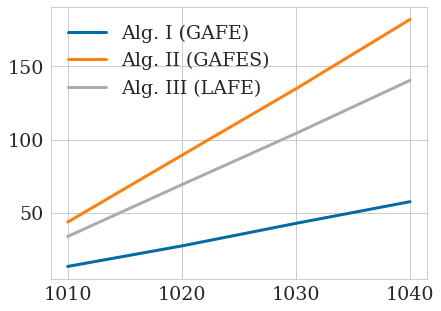

In [28]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()


Calculate slopes and add fixed time stepping

In [29]:
#start with tissue (~500 cells?)
size = 10
coords = ut.generate_hcp_coordinates(size, size, size)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

frequency = 0.3
event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]

target_cell_counts = [1010, 1020, 1030]
max_execution_time = 10*60 # 10 minutes in seconds

EF_glob_adap_acc
EF_glob_adap_stab
EF_local_adap


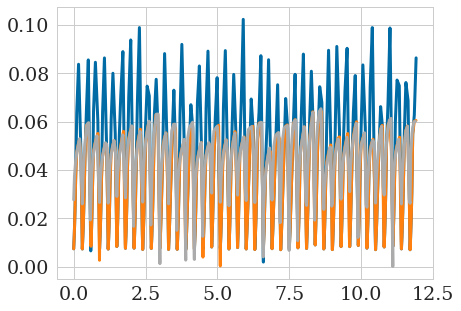

In [30]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    plt.plot(ts[:-2], np.diff(ts[:-1]))
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)

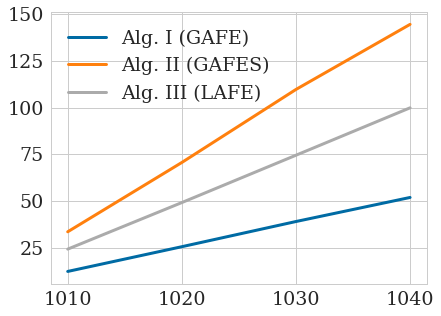

In [31]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()


The smaller the time between cell divisions, the more the local time stepping algorithm pays off compared to GAFES. Can it ever reach GAFE? There also has to be a lower limit when fixed time stepping becomes more efficient. What if after every time step a cell divides somewhere? I guess the time between divisions should not be smaller than sqrt(m)*dt_GAFE. Or else LAFE cannot benefit. 
Right now m=14, dt_GAFE = 0.007, ie. the minimal time should be no smaller than 0.026. Which is an order of magnitude smaller than what I tried out so far.

In [32]:
np.sqrt(14)*0.007

0.026191601707417588

In [33]:
#start with tissue (~500 cells?)
size = 10
coords = ut.generate_hcp_coordinates(size, size, size)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

frequency = 0.03
event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]

target_cell_counts = [1010, 1020, 1030]
max_execution_time = 10*60 # 10 minutes in seconds

EF_glob_adap_acc
EF_glob_adap_stab
EF_local_adap


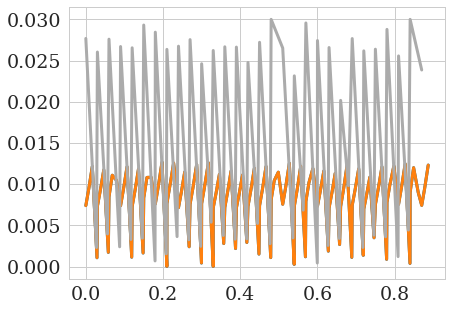

In [34]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    plt.plot(ts[:-2], np.diff(ts[:-1]))
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)

Okay, LAFE is taking weird steps here.

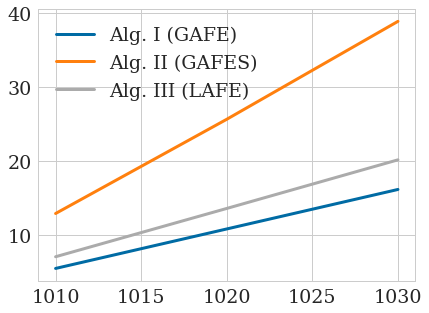

In [35]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()

I guess one can never beat GAFE... 

Can I do adding 20 cells for a population of 5000 cells locally? Or do I run out of memory there? (And would have to run it on rackham?)

In [12]:
#start with tissue (~500 cells?)
size = 13 #2197
coords = ut.generate_hcp_coordinates(size, size, size)
tissue = [cl.Cell(i, [x, y, z]) for i, (x, y, z) in enumerate(coords)]

frequency = 0.05
event_times = np.arange(0.0, tf, frequency)

events = [ev.PickRandomCellToDivideEvent(time) for time in event_times]

target_cell_counts = [2200, 2210, 2220]
max_execution_time = 10*60 # 10 minutes in seconds

EF_glob_adap_acc
EF_glob_adap_stab


MemoryError: Unable to allocate 332. MiB for an array with shape (2198, 2198, 3, 3) and data type float64

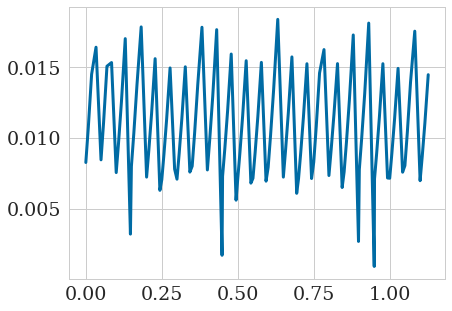

In [13]:
data = {}
for alg in algorithms:
    print(alg)
    ts, history = models[alg].simulate(tissue, 
                                      [0, tf], 
                                      params_cubic, 
                                      params[alg],  
                                      seed=seed, 
                                      event_list=events,
                                      n_target_cells=target_cell_counts,
                                      max_execution_time=max_execution_time,
                                      throw_away_history=True
                                     )
    plt.plot(ts[:-2], np.diff(ts[:-1]))
    data[alg] = np.array(models[alg].target_cell_count_checkpoints)

In [ ]:
for alg in algorithms:
    plt.plot(data[alg][:, 1], data[alg][:, 2], label=labels[alg])
    
plt.legend()

In [11]:
13*13*13

2197